In [1]:
!pip install praat-parselmouth
!pip install --upgrade librosa
!pip install librosa scipy
!pip install datasets
!pip install pysptk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.9/461.9 kB 7.3 MB/s eta 0:00:00
 

In [2]:
import pandas as pd
import numpy as np
import librosa
import parselmouth
from parselmouth.praat import call
import scipy.stats as stats

In [3]:
import scipy
from scipy.signal import lfilter #hamming
import pysptk
from scipy.io import wavfile
from tqdm import tqdm

In [16]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load File

In [17]:
df = pd.read_csv('/content/drive/Shared drives/CS298/CS 297/IEMOCAP/LabeledIemocap.csv')

In [20]:
df.head()

,Session,Conversation,Audio_Path,Speaker_id,Transcript,Time_Frame,Major_emotion,Audio_Uttrance_Path,Final_class
0,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M000,Good God.,006.2551-008.1400,Frustration,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Nervous
1,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_F000,Do you think it's them?,007.7500-009.1900,Frustration,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Nervous
2,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M001,I wonder.,008.6300-009.6700,Fear,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Nervous
3,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_F001,Nobody knows we're here except Freda and she w...,009.2300-011.8600,Frustration,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Nervous
4,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M002,It must be them then.,011.4300-012.7900,Fear,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Nervous


In [18]:
len(df)

1926

In [21]:
df['Audio_Uttrance_Path'] = df['Audio_Uttrance_Path'].str.replace('/content/drive/My Drive', '/content/drive/Shareddrives/CS298')

In [24]:
df['Audio_Uttrance_Path'].iloc[0]

'/content/drive/Shareddrives/CS298/CS 297/IEMOCAP/Session4/Audio_Uttrances/Ses04F_script03_1/Ses04F_script03_1_M000.wav'

## Test the audio Sample

In [23]:
import librosa
import numpy as np
import scipy
from scipy.signal import lfilter #, hamming
import pysptk
from scipy.io import wavfile
def extract_extended_features(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=16000, mono=True)

    # Reduce noise using noisereduce
    # y = nr.reduce_noise(y=y, sr=sr, thresh_n_mult_nonstationary=2, stationary=False)

    # Features dictionary
    features = {}

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=45)
    for i, mfcc in enumerate(mfccs):
        features[f'MFCC_{i}'] = np.mean(mfcc)

    # Pitch
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0])
    pitch_std = np.std(pitches[pitches > 0])
    features['Pitch_mean'] = pitch_mean
    features['Pitch_std'] = pitch_std

    # Energy
    rmse = librosa.feature.rms(y=y)
    features['Energy_mean'] = np.mean(rmse)
    features['Energy_std'] = np.std(rmse)

    # Spectral Centroid
    spec_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['Spectral_Centroid_mean'] = np.mean(spec_centroids)
    features['Spectral_Centroid_std'] = np.std(spec_centroids)

    # Spectral Bandwidth, Rolloff, RMS Energy
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['Spectral_Bandwidth_Mean'] = np.mean(spectral_bandwidth)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['Spectral_Rolloff_Mean'] = np.mean(rolloff)
    rms_energy = librosa.feature.rms(y=y)
    features['RMS_Energy_Mean'] = np.mean(rms_energy)

    # Chroma Features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    for i, chroma in enumerate(chroma_stft):
        features[f'Chroma{i}'] = np.mean(chroma)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features['ZCR_mean'] = np.mean(zcr)
    features['ZCR_std'] = np.std(zcr)

    # Loudness (using Energy)
    S, phase = librosa.magphase(librosa.stft(y))
    rms_s = librosa.feature.rms(S=S)
    features['Loudness'] = np.mean(librosa.amplitude_to_db(rms_s, ref=np.max))

    # Mel-Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    features['Mel_Spec_Mean'] = np.mean(mel_spec)

    # LPC - Linear Predictive Coefficients
    lpc_coefficients = librosa.lpc(y, order=10)
    for i, coeff in enumerate(lpc_coefficients):
        features[f'LPC_{i}'] = coeff

    return features


## Feature Extraction

In [26]:
import time
import pandas as pd
from tqdm import tqdm

features_list = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    features = extract_extended_features(row['Audio_Uttrance_Path'])
    features['Emotion'] = row['Final_class']
    features['Speaker_id'] = row['Speaker_id']
    features_list.append(features)

Extracting features: 100%|██████████| 1926/1926 [13:44<00:00,  2.34it/s]


In [27]:
df = pd.DataFrame(features_list)
df.to_csv("features_updated_data_audio_iemocap_All_tokens.csv", index=False)

In [49]:
features_df = pd.read_csv("features_updated_data_audio_iemocap_All_tokens.csv")

In [50]:
features_df.head()

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,LPC_3,LPC_4,LPC_5,LPC_6,LPC_7,LPC_8,LPC_9,LPC_10,Emotion,Speaker_id
0,-461.11490,112.019135,-18.254726,30.989008,-8.022955,14.530048,-7.674868,8.910705,-7.732786,9.042817,...,-4.309030,4.279380,-4.038268,3.407102,-2.520523,1.698326,-0.914442,0.256774,Nervous,Ses04F_script03_1_M000
1,-353.95483,110.984950,-32.917450,44.376503,-28.212843,1.377860,-18.755830,6.655478,-10.875289,8.713849,...,-3.055055,3.183594,-3.009275,2.519618,-1.901345,1.272239,-0.685757,0.256214,Nervous,Ses04F_script03_1_F000
2,-307.39905,139.353800,-55.655650,35.709640,-24.282598,-8.041896,-15.103068,-7.157278,-6.234849,4.638667,...,-4.981248,4.880449,-4.198057,3.281164,-2.435601,1.757024,-1.040697,0.348874,Nervous,Ses04F_script03_1_M001
3,-323.83505,105.736390,-38.897120,35.654343,-16.976439,5.943921,-29.648062,-9.719378,-9.015412,-0.471111,...,-3.579711,3.813991,-3.708133,3.339677,-2.777850,2.047910,-1.184414,0.412443,Nervous,Ses04F_script03_1_F001
4,-381.90390,112.582700,-28.641914,41.377426,-14.992129,13.524291,-15.060655,0.119447,-9.428417,12.295828,...,-3.461308,3.362551,-3.217988,2.886278,-2.236722,1.461330,-0.787530,0.277015,Nervous,Ses04F_script03_1_M002


## EMotions updation

In [51]:
unique_values_count = features_df['Emotion'].nunique()
print("Number of unique values in the 'Emotion' column:", unique_values_count)

Number of unique values in the 'Emotion' column: 7


In [52]:
# Strip and convert to lowercase all values in the 'Emotion' column
features_df['Audio_Uttrance_Path'] = features_df['Emotion'].str.strip().str.lower()

In [53]:
features_df.dropna(subset=['Emotion'], inplace=True)

In [59]:
emotion_counts = features_df['Emotion'].str.strip().str.lower().value_counts()
print(features_df['Emotion'].value_counts())

Emotion
Happy      522
Neutral    456
Angry      426
Sad        346
Nervous    131
Fear        34
Excited     11
Name: count, dtype: int64


In [62]:
features_df['Emotion'] = features_df['Emotion'].replace({'Excited': 'Happy'})

In [60]:
# Drop rows with 'fear' and 'nervous' categories
features_df = features_df[features_df['Emotion'] !='Fear' ]
features_df = features_df[features_df['Emotion'] !='Nervous' ]

In [63]:
print(features_df['Emotion'].value_counts())

Emotion
Happy      533
Neutral    456
Angry      426
Sad        346
Name: count, dtype: int64


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [103]:
X = features_df.iloc[:, :81]
y = features_df['Emotion']

In [104]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [105]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

## Train-Test SPlit


In [106]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data
for train_index, test_index in sss.split(X_scaled, y_categorical):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

# Reshape input
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

#BiLSTM


In [107]:
# Defining the model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [108]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [109]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)

In [110]:
history = model.fit(
    X_train_reshaped,
    y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4306 - loss: 1.2931 - val_accuracy: 0.5035 - val_loss: 1.1382
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5805 - loss: 1.0177 - val_accuracy: 0.5709 - val_loss: 1.0296
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6685 - loss: 0.8587 - val_accuracy: 0.5780 - val_loss: 0.9939
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6964 - loss: 0.7704 - val_accuracy: 0.5993 - val_loss: 0.9732
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7515 - loss: 0.6895 - val_accuracy: 0.6028 - val_loss: 0.9586
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7433 - loss: 0.6465 - val_accuracy: 0.6383 - val_loss: 0.9626
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7508 - loss: 0.6080 - val_accuracy: 0.6418 - val_loss: 0.9554
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8005 - loss: 0.5338 - val_accuracy: 0.6418 - val_loss

In [111]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f'Test accuracy: {accuracy*100:.2f}%')

Test accuracy: 66.01%


In [112]:
from sklearn.metrics import f1_score
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

#  F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'F1 Score: {f1:.4f}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
F1 Score: 0.6583


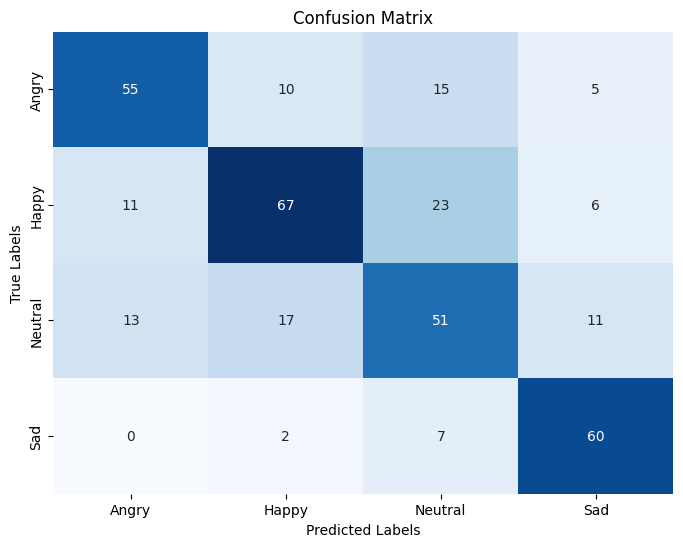

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert encoded labels back to categorical labels
y_true_labels = label_encoder.inverse_transform(y_true)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Define the category names for plotting
label_names = label_encoder.classes_

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix with categorical labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [114]:
pip install keras-tuner

Reloading Tuner from my_dir/keras_tuner_bilstm/tuner0.json
Best Hyperparameters:
units: 160
dropout: 0.1
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4085 - loss: 1.2837 - val_accuracy: 0.4752 - val_loss: 1.1430
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5810 - loss: 1.0113 - val_accuracy: 0.5355 - val_loss: 1.0430
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6501 - loss: 0.8876 - val_accuracy: 0.5567 - val_loss: 0.9974
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6848 - loss: 0.8052 - val_accuracy: 0.6064 - val_loss: 0.9686
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7282 - loss: 0.6896 - val_accuracy: 0.6028 - val_loss: 0.9749
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7841 - loss: 0.6101 - val_accuracy: 0.6312 - val_loss: 0.9522
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7830 - loss: 0.5557 - val_accuracy: 0.6206 - val_loss: 0.9743
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7967 - loss: 0.5323 - val_accuracy: 0.6454 - val_loss: 0.9873
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71        85
           1       0.70      0.64      0.67       107
           2       0.56      0.53      0.54        92
           3       0.72      0.84      0.77        69

    accuracy                           0.67       353
   macro avg       0.67      0.68      0.68       353
weighted avg       0.67      0.67      0.67       353



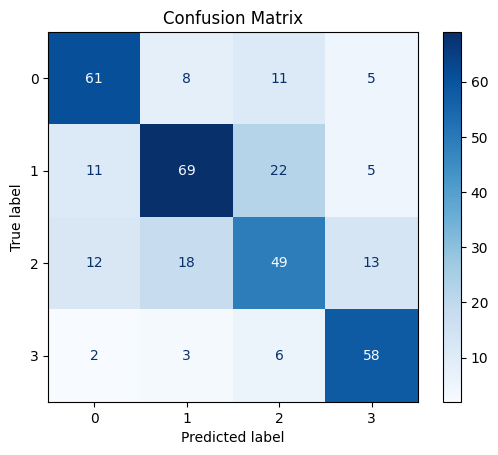

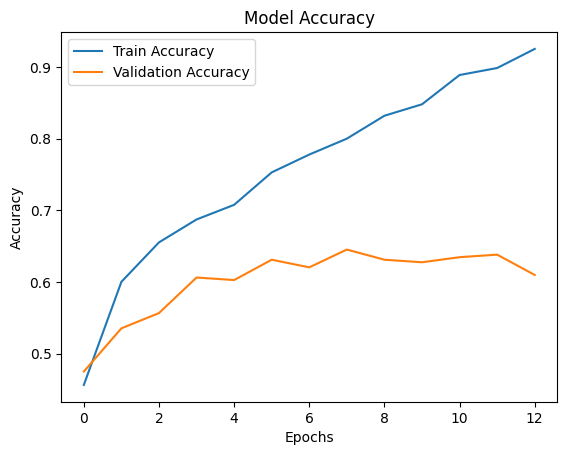

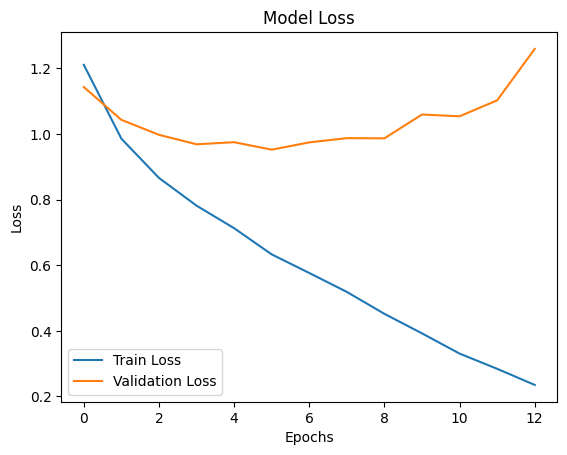

In [115]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Attention
from tensorflow.keras.models import Model
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Set up an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Define the model-building function for hyperparameter tuning
def build_model(hp):
    inputs = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
    x = Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True))(inputs)
    x = Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05))(x)
    # Attention layer
    query_value_attention_seq = Attention()([x, x])
    x = LSTM(64)(query_value_attention_seq)
    outputs = Dense(y_train.shape[1], activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Set up the Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_bilstm'
)

# Run hyperparameter tuning
tuner.search(X_train_reshaped, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])

# Retrieve and print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

# Build the final model using the best hyperparameters
best_model = build_model(best_hps)

# Train the model using the best hyperparameters
history = best_model.fit(X_train_reshaped, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on the test data
y_pred = np.argmax(best_model.predict(X_test_reshaped), axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot training accuracy and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Confusion Matrix:
[[58  8 14  5]
 [10 62 29  6]
 [11 22 43 16]
 [ 1  2  4 62]]


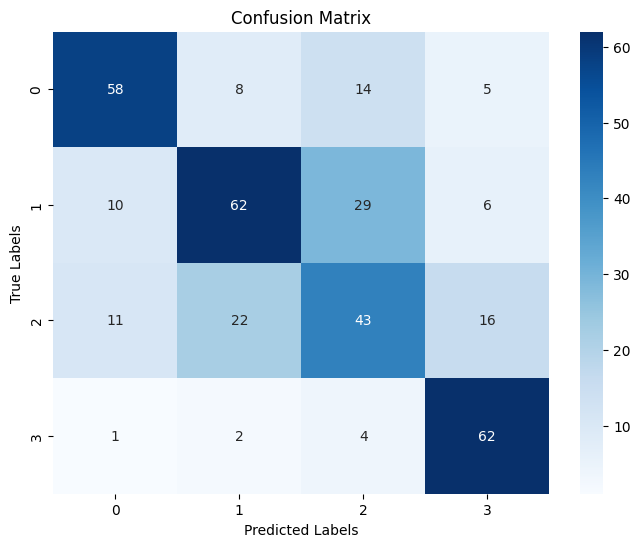

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_test_reshaped), axis=-1)
conf_mat = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('Confusion Matrix:')
print(conf_mat)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [116]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

In [117]:
def transformer_encoder(inputs):
    # Multi-head self-attention
    x = MultiHeadAttention(num_heads=2, key_dim=2)(inputs, inputs)
    x = Dropout(0.1)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward neural network
    ffnn = Dense(units=inputs.shape[-1], activation='relu')(x)
    ffnn_output = Dense(units=inputs.shape[-1])(ffnn)
    x = Dropout(0.1)(ffnn_output)
    encoder_output = LayerNormalization(epsilon=1e-6)(x + ffnn_output)
    return encoder_output

In [118]:
input_shape = X_train_reshaped.shape[1:]  # Example: (sequence_length, feature_dim)
inputs = Input(shape=input_shape)
x = transformer_encoder(inputs)
x = GlobalAveragePooling1D()(x)
outputs = Dense(y_categorical.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 1, 81)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 1, 81)          │          1,389 │ input_layer_8[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 1, 81)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1, 81)          │              0 │ dropout_16[0][0],      │
│                           │                        │                │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 1, 81)          │            162 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 1, 81)          │          6,642 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 1, 81)          │          6,642 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 1, 81)          │              0 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 1, 81)          │              0 │ dropout_17[0][0],      │
│                           │                        │                │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 1, 81)          │            162 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 81)             │              0 │ layer_normalization_3… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 4)              │            328 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,325 (59.86 KB)

 Trainable params: 15,325 (59.86 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the Transformer model
history = model.fit(X_train_reshaped, y_train,
                    epochs=50,
                    batch_size=34,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.1947 - loss: 2.0591 - val_accuracy: 0.2553 - val_loss: 1.7105
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2463 - loss: 1.6899 - val_accuracy: 0.3156 - val_loss: 1.4787
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3526 - loss: 1.4109 - val_accuracy: 0.3652 - val_loss: 1.3540
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4034 - loss: 1.2808 - val_accuracy: 0.4113 - val_loss: 1.2778
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4849 - loss: 1.1761 - val_accuracy: 0.4362 - val_loss: 1.2310
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5193 - loss: 1.1393 - val_accuracy: 0.4610 - val_loss: 1.1972
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5504 - loss: 1.0821 - val_accuracy: 0.4823 - val_loss: 1.1683
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5619 - loss: 1.0671 - val_accuracy: 0.5035 - val_loss: 1.1486
E

In [120]:
from tensorflow import keras
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.argmax(y_test, axis=1)

# Accuracy
accuracy = np.mean(y_pred == y_true)
print(f'Transformer Model Accuracy: {accuracy:.4f}')

# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Transformer Model F1 Score: {f1:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Transformer Model Accuracy: 0.6261
Transformer Model F1 Score: 0.6210


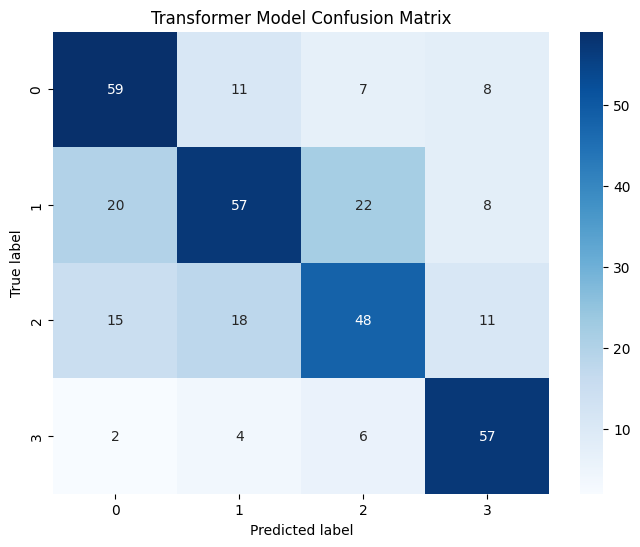

In [121]:
# Convert predicted labels to categorical format
y_pred_categorical = keras.utils.to_categorical(y_pred, num_classes=y_categorical.shape[1])

# Convert true labels to categorical format
y_true_categorical = keras.utils.to_categorical(y_true, num_classes=y_categorical.shape[1])

# Calculate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_true_categorical, axis=1), np.argmax(y_pred_categorical, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Transformer Model Confusion Matrix')
plt.show()

#openSmile


In [85]:
!pip install pyopensmile

ERROR: Could not find a version that satisfies the requirement pyopensmile (from versions: none)
ERROR: No matching distribution found for pyopensmile


In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [123]:
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.3430 - loss: 1.3340 - val_accuracy: 0.5248 - val_loss: 1.1112
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4931 - loss: 1.1291 - val_accuracy: 0.5709 - val_loss: 1.0731
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5456 - loss: 1.0082 - val_accuracy: 0.5638 - val_loss: 1.0387
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5909 - loss: 0.9486 - val_accuracy: 0.5638 - val_loss: 1.0412
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6406 - loss: 0.8848 - val_accuracy: 0.5426 - val_loss: 1.0226
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6484 - loss: 0.8437 - val_accuracy: 0.5851 - val_loss: 0.9941
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6546 - loss: 0.8447 - val_accuracy: 0.5745 - val_loss: 0.9727
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6922 - loss: 0.7770 - val_accuracy: 0.5993 - val_loss

In [124]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6567 - loss: 0.9472
Test Accuracy: 65.44%


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6567 - loss: 0.9472 
Test Accuracy: 0.6544
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        85
           1       0.71      0.61      0.65       107
           2       0.58      0.45      0.50        92
           3       0.70      0.88      0.78        69

    accuracy                           0.65       353
   macro avg       0.65      0.67      0.65       353
weighted avg       0.65      0.65      0.65       353



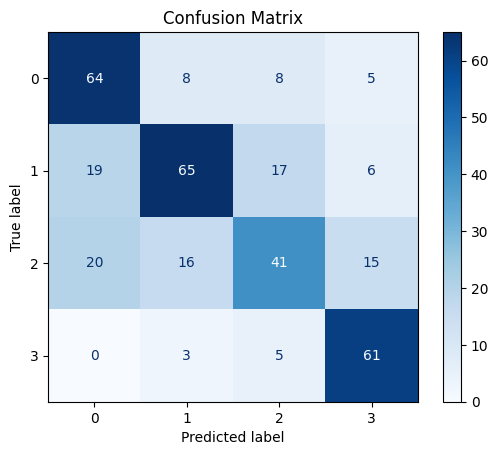

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on test data and generate predictions
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on the test data
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [127]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Dense(256),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Dense(128),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

# optimizer = Adam(learning_rate=0.0001)
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [128]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.2637 - loss: 1.9829 - val_accuracy: 0.4433 - val_loss: 1.2602
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3393 - loss: 1.7494 - val_accuracy: 0.4858 - val_loss: 1.1977
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3985 - loss: 1.5584 - val_accuracy: 0.5142 - val_loss: 1.1687
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4049 - loss: 1.5204 - val_accuracy: 0.5213 - val_loss: 1.1467
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4286 - loss: 1.4253 - val_accuracy: 0.5106 - val_loss: 1.1364
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4496 - loss: 1.3788 - val_accuracy: 0.5248 - val_loss: 1.1361
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4684 - loss: 1.3497 - val_accuracy: 0.5355 - val_loss: 1.1299
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4943 - loss: 1.2422 - val_accuracy: 0.5355 - val_loss

In [129]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5976 - loss: 0.9777
Test Accuracy: 61.47%


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5976 - loss: 0.9777 
Test Accuracy: 0.6147
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        85
           1       0.67      0.52      0.59       107
           2       0.53      0.45      0.48        92
           3       0.62      0.88      0.73        69

    accuracy                           0.61       353
   macro avg       0.61      0.64      0.62       353
weighted avg       0.61      0.61      0.61       353



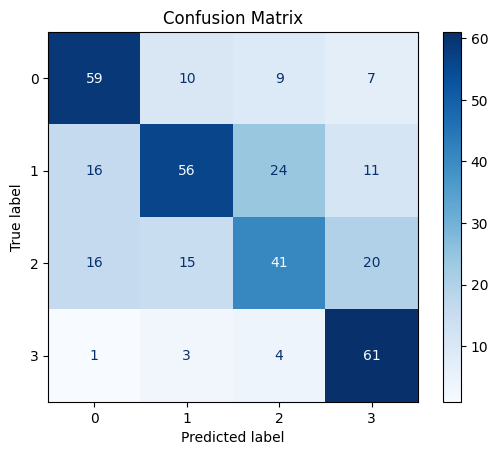

In [130]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on test data and generate predictions
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on the test data
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



In [97]:

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5897 - loss: 0.9535 
Test Accuracy: 60.91%
